# reliability.space
## Reliability Prediction - FORM
## Bearing:     solid lubricant wear model

For ESA RFP 17225,
by Matthias Schubert, 2021-09-23

## General model

Solid lubricant wear modelling is described taking example in a ball bearing. The modelling is applicable to other cases of solid lubricant wear, however, the number of revolution has to be substituted with another measure of sliding distance. 
For solid lubricant reservoir wear (e.g. cage of a ball bearing), the limit state function for the adhesive wear model is formulated as follows:

$g\left( {\bf{X}} \right) = {V_{{\rm{limit}}}} - \Theta  \cdot \sum\limits_{i = 1}^{{n_p}} {{K_{H,i}} \cdot {\alpha _i} \cdot re{v_i}}$

Where $\alpha$ denotes the average work of ball/cage interaction forces per revolution and $rev_i$ the number of revolutions in time interval $i$ . The parameter $\alpha$ will typically be estimated from tests and is, thus dependent on the wear rate $K_H$ , which is used to estimate $\alpha$ from the test results. Therefore, $K_H$ cannot be easily taken out of the sum.

The following calculation is done by using First Order Reliability Analysis (FORM) for one time interval i=1.

In [1]:
# nbi:hide_in
#   IMPORTs
from IPython.display import display 
import ipywidgets as widgets 
from ipywidgets import interact, Layout
import numpy as np
from scipy.stats import norm
import matplotlib
from matplotlib import pyplot as plt
from ipywidgets import interact
import nbinteract as nbi
import pyre
from pyre import *

In [2]:
# nbi:hide_in
def proF(E_Vlim,COV_Vlim,Dist_Vlim,E_KH,COV_KH,Dist_KH,E_alpha,COV_alpha,Dist_alpha,E_MU,COV_MU,Dist_MU,E_nrev,Rev_per_hour):
    
    E_vlimit_val = float(E_Vlim)
    nu_vlimit_val = float(COV_Vlim)
    E_KH_val = float(E_KH)
    nu_KH_val = float(COV_KH)
    E_alpha_val = float(E_alpha)
    nu_alpha_val = float(COV_alpha)
    E_theta_val = float(E_MU)
    nu_theta_val = float(COV_MU)
    rev_val = float(E_nrev)
    rev_hour= float(Rev_per_hour)

    rev_min=rev_val*0.5;  #for plotting
    rev_max=rev_val*2;  #for plotting

    mu_R=E_vlimit_val
    sigma_R=E_vlimit_val*nu_vlimit_val
    x_R_mat=np.linspace(mu_R-sigma_R*4,mu_R+sigma_R*4,50); 
    
    mu_S=E_KH_val*E_alpha_val*E_theta_val*rev_val
    cov_S=((nu_KH_val)**2+(nu_alpha_val)**2+(nu_theta_val)**2)**0.5
    sigma_S=cov_S*mu_S;
    x_S_mat=np.linspace(max(mu_S-sigma_S*3,1e-12),mu_S+sigma_S*6,100)
    zeta_S = (np.log(1+(sigma_S/mu_S)**2))**0.5
    lamb_S = np.log(mu_S) - 0.5*zeta_S**2
    S_pdf=pyre.distributions.lognormal.Lognormal.pdf(x_S_mat,lamb_S,zeta_S)
    
    #revolutions per hour
    #rev_hour=100;
    ######################################################


    # FORM ANALYSIS PyRe
    
    
    stochastic_model = StochasticModel()
    # Define random variables
    
    if Dist_Vlim=='Normal':
        stochastic_model.addVariable( Normal('X1',E_vlimit_val,E_vlimit_val*nu_vlimit_val) )
        
        R_pdf=pyre.distributions.normal.Normal.pdf(x_R_mat,mu_R,sigma_R)
        
    elif Dist_Vlim=='LogNormal':
        stochastic_model.addVariable( Lognormal('X1',E_vlimit_val,E_vlimit_val*nu_vlimit_val) )
        
        
        #Lognormal
        zeta_R = (np.log(1+nu_vlimit_val**2))**0.5
        lamb_R = np.log(mu_R) - 0.5*zeta_R**2
        R_pdf=pyre.distributions.lognormal.Lognormal.pdf(x_R_mat,lamb_R,zeta_R)
    
        
    elif Dist_Vlim=='Gumbel':
        stochastic_model.addVariable( Gumbel('X1',E_vlimit_val,E_vlimit_val*nu_vlimit_val) )
    
        #Gumbel
        a_n_R = np.pi*(sigma_R*np.sqrt(6))**(-1)
        u_n_R = mu_R - (0.5772156649*sigma_R*np.sqrt(6))*(np.pi)**(-1)
        R_pdf=pyre.distributions.gumbel.Gumbel.pdf(x_R_mat,u_n_R,a_n_R)
        
    if Dist_KH=='Normal':
        stochastic_model.addVariable( Normal('X2',E_KH_val,E_KH_val*nu_KH_val) )
        
    elif Dist_KH=='LogNormal':
        stochastic_model.addVariable( Lognormal('X2',E_KH_val,E_KH_val*nu_KH_val) )
        
    elif Dist_KH=='Gumbel':
        stochastic_model.addVariable( Gumbel('X2',E_KH_val,E_KH_val*nu_KH_val) )
    
    if Dist_alpha=='Normal':
        stochastic_model.addVariable( Normal('X3',E_alpha_val,E_alpha_val*nu_alpha_val) )
    elif Dist_alpha=='LogNormal':
        stochastic_model.addVariable( Lognormal('X3',E_alpha_val,E_alpha_val*nu_alpha_val) )
    elif Dist_alpha=='Gumbel':
        stochastic_model.addVariable( Gumbel('X3',E_alpha_val,E_alpha_val*nu_alpha_val) )  
        
    stochastic_model.addVariable( Lognormal('X4',E_theta_val,E_theta_val*nu_theta_val) )
    
    stochastic_model.setCorrelation( CorrelationMatrix([[1.0, 0.0, 0.0, 0.0],
                                                        [0.0, 1.0, 0.5, 0.0],
                                                        [0.0, 0.5, 1.0, 0.0],
                                                        [0.0, 0.0, 0.0, 1.0]]) )
    
    # Set some options (optional)
    options = AnalysisOptions()
    # options.printResults(False)
    #aplha=computeAlpha()

    # Define limit state function
    limit_state = LimitState(lambda X1,X2,X3,X4: X1-X2*X3*X4*rev_val)
    # Performe FORM analysis
    Analysis = Form(analysis_options=options, stochastic_model=stochastic_model, limit_state=limit_state)
    # Some single results:
    beta = Analysis.getBeta()
    pf = Analysis.getFailure()
    
    
    
    pf_mat=[]
    rev_mat=np.linspace(rev_val*0.8,rev_val*1.2,5); 
    # for plot of the "Resistance"
    for i_rev in range(rev_mat.shape[0]):
        # Define limit state function
        limit_state = LimitState(lambda X1,X2,X3,X4: X1-X2*X3*X4*rev_mat[i_rev])
        # Performe FORM analysis
        options.printResults(False)
        Analysis = Form(analysis_options=options, stochastic_model=stochastic_model, limit_state=limit_state)
        pf_mat.append(Analysis.getFailure())

    
    #rev_mat=np.linspace(rev_min,rev_max,50);

    #pf_mat=[]
    #for i_rev in range(rev_mat.shape[0]):
    #        E_x2 = (E_KH_val*E_alpha_val + nu_KH_alpha)*rev_mat[i_rev];
    #        nu_x2 = 1/E_x2*rev_mat[i_rev]*np.sqrt(var_KH_alpha);

    #       pf_mat.append( norm.cdf((np.log(E_theta_val) - np.log(E_x1/E_x2) + 0.5*(np.log(nu_x1**2 + 1) -  np.log(nu_x2**2 + 1) - np.log(nu_theta_val**2 + 1))) / np.sqrt(np.log( nu_theta_val**2 + 1 ) + np.log( nu_x1**2 + 1 ) + np.log( nu_x2**2 + 1 ))) )

 
    plt.figure(1)
    #%matplotlib inline
    plt.plot(x_R_mat, R_pdf,'b-')
    plt.plot(x_S_mat, S_pdf,'r-')
    #plt.plot(np.log10(rev_val), pf,'ro')
    plt.xlabel('Volume [m^3]')
    plt.ylabel('probability density function')
    plt.legend(['Limiting Volume','Volume worn away'])

    #plt.yscale('log')
    plt.figure(2)
    
    plt.plot(rev_val/(rev_hour*365*24),pf,'ro')
    plt.plot( rev_mat/(rev_hour*365*24),pf_mat,'r--')
        
    plt.ylabel('probability of failure')
    plt.xlabel('years')
    #plt.legend(['Limiting Volume','Volume worn away'])
    
    return 'The probability of failure is pf={} at {} revolutions'.format(pf,rev_val)
   

## Input values for reliability prediction
#### -Limiting value (worn volume), $V_{lim}$ $[m^3]$, described by: Mean Value, Coefficient of Variation and Distribution
#### -Specific wear rate, $K_H$ $[Pa^{-1}=m^2/N]$ , described by: Mean Value, Coefficient of Variation and Distribution
#### -Ball-cage interaction, $\alpha$ $[N/m]$ , described by: Mean Value, Coefficient of Variation and Distribution
#### -Model uncertainty, $\Theta$ $[-]$ , described by: Mean Value, Coefficient of Variation, Lognomal distribution
#### -Nominal number of revolutions, $rev$ $[ \# ]$, described by: Integer Value
#### -Average number of revolution per hour (for plotting only) 

interactive(children=(Text(value='6.5e-8', description='E_Vlim'), Text(value='0.2', description='COV_Vlim'), D…

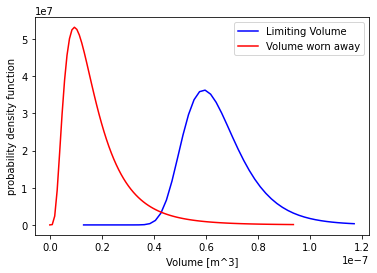

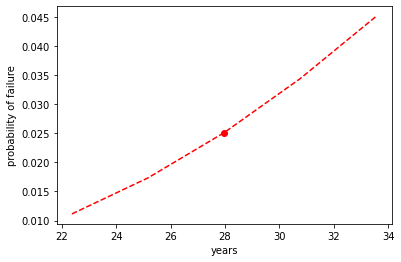

In [3]:
# nbi:hide_in
interact(proF, E_Vlim='6.5e-8', COV_Vlim='0.2', Dist_Vlim={'LogNormal', 'Normal','Gumbel'}, E_KH='4e-15', COV_KH='0.66', Dist_KH={'LogNormal', 'Normal','Gumbel'}, E_alpha='0.018', COV_alpha='0.2', Dist_alpha={'LogNormal', 'Normal','Gumbel'}, E_MU='1.0', COV_MU='0.2', Dist_MU={'LogNormal'}, E_nrev='245e+6',Rev_per_hour='1000');